<a href="https://colab.research.google.com/github/GreatArcStudios/APS360/blob/master/Lab%202/Lab2%20Cats%20vs%20Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: 

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [4]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

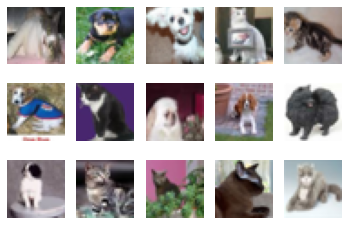

In [5]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [6]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(50000, 50000, 10000)

There is 50000+50000+10000 samples, which is a total of 110000 samples

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

THe validation set is used for tuning hyperparameters, e.g., learning rate, number of hidden units, layers, etc.... This is done to prevent biasing model training to optimize over the test set, which should be "out of sample" data, i.e., the test set is used to mirror new data you'd get when deploying a model. If you tune your hyperparameters on the test set rather than the validation, then you cannot trust your test set loss to be representative of future performance.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [7]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [9]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [13]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [14]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


From above, we see that small net has a total of $5 \times 3 \times 3 \times 3 + 5 + 245 + 1 = 386$ parameters, while large net has a total of $5 \times 3 \times 5 \times 5 + 5 + 10 \times 5^3 + 10 + 32 \times 250 + 32 + 32 + 1 = 9705$ parameters. 

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [19]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

The default parameters for `batch_size`, `learning_rate`, and `num_epochs` respectively are: $64, 0.01, 30$.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

We have the following files: 


1.   The model state dictionary that can be used to reinitalize the model: `model_small_bs64_lr0.01_epoch4`
2.   Training error vector over epochs: `model_small_bs64_lr0.01_epoch4_train_err.csv`
3.   Training loss vector over epochs `model_small_bs64_lr0.01_epoch4_train_loss.csv`
4.   Validation err vector over epochs `model_small_bs64_lr0.01_epoch4_val_err.csv`
5.   Validation loss vector over epochs `model_small_bs64_lr0.01_epoch4_val_loss.csv`

Note: we use the following formatting: model_small_bs64_lr0.01_epoch4


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

In [16]:
small_net_trained = train_net(small_net)
large_net_trained = train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42075, Train loss: 0.6723377504348755 |Validation err: 0.3945, Validation loss: 0.6595788542181253
Epoch 2: Train err: 0.372125, Train loss: 0.6458917841911316 |Validation err: 0.383, Validation loss: 0.6515465062111616
Epoch 3: Train err: 0.343125, Train loss: 0.6254546680450439 |Validation err: 0.3425, Validation loss: 0.6258589867502451
Epoch 4: Train err: 0.337125, Train loss: 0.609498464345932 |Validation err: 0.369, Validation loss: 0.6355494987219572
Epoch 5: Train err: 0.322375, Train loss: 0.5989378657341003 |Validation err: 0.3405, Validation loss: 0.6206743214279413
Epoch 6: Train err: 0.310875, Train loss: 0.5884755213260651 |Validation err: 0.326, Validation loss: 0.6120300143957138
Epoch 7: Train err: 0.310625, Train loss: 0.5866070160865784 |Validation err: 0.321, Validation loss: 0.6046791933476925
Epoch 8: Train err: 0.307125, Train loss: 0.5793938844203949 |Validation err

Small net took 120 seconds to train, while large net took 130 seconds. Large net should take longer since it has more parameters, meaning it is requires more operations for the processor to perform gradient descent updates and gradient calculations. 

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

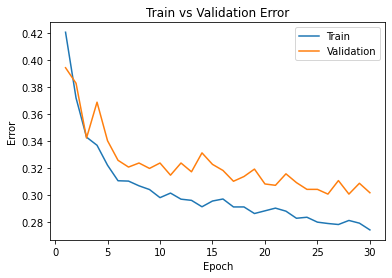

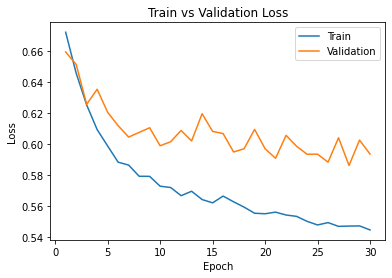

In [19]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

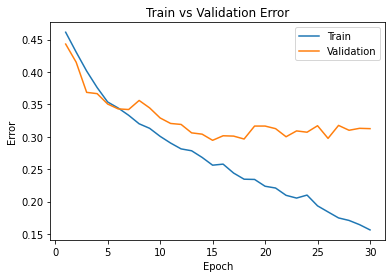

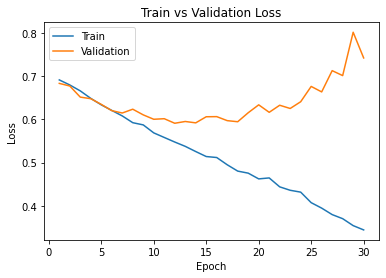

In [20]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

We see that for the small net, the training/validation loss curves look fairly well behaved. In that, the loss still appears to be going for both the validation and training curves, while the error very much is still going down. This means we may still have a somewhat underfit model on the small net, and could require further training. However, on the large net, we see that while the training loss rapidly decreases, the validation loss is going up rapidly too, and the validation error is starting to increase, despite a decreasing training error. This is textbook overfitting as we are memorizing the data noise on the training set for the large net. 

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6945205240249633 |Validation err: 0.491, Validation loss: 0.6929903607815504
Epoch 2: Train err: 0.50225, Train loss: 0.6930275931358337 |Validation err: 0.491, Validation loss: 0.6924116816371679
Epoch 3: Train err: 0.487375, Train loss: 0.6922533187866211 |Validation err: 0.4765, Validation loss: 0.6920256800949574
Epoch 4: Train err: 0.448625, Train loss: 0.6916869764328003 |Validation err: 0.4515, Validation loss: 0.6913820113986731
Epoch 5: Train err: 0.44225, Train loss: 0.6910718812942505 |Validation err: 0.4415, Validation loss: 0.6910950168967247
Epoch 6: Train err: 0.44025, Train loss: 0.6903757758140564 |Validation err: 0.437, Validation loss: 0.6905075237154961
Epoch 7: Train err: 0.43825, Train loss: 0.6895534009933472 |Validation err: 0.434, Validation loss: 0.6896947920322418
Epoch 8: Train err: 0.439, Train loss: 0.6884737334251404 |Validation err: 0.43

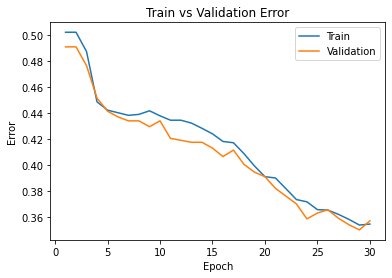

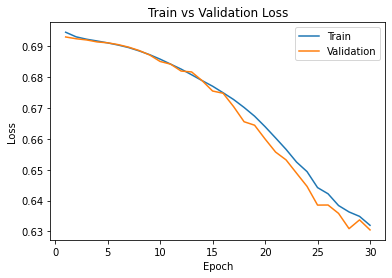

In [22]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
large_net_small_lr = train_net(large_net, learning_rate=0.001)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

Training took roughly the same amount of time, i.e., 130 seconds vs 133 seconds.This makes sense as we are just multiplying the gradient computation by a smaller amount, so the operations are the same. However, we do see that the loss curves are much better behaved, i.e., we haven't started to overfit yet, and it appears that we can keep training the model (currently underfit). The training error is higher while the validation error is about the same as the default parameters. The loss curves are also a lot smoother as we don't "bounce" around the loss landscape nearly as much with a smaller learning rate.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.467625, Train loss: 0.6861868515014649 |Validation err: 0.4215, Validation loss: 0.6740307230502367
Epoch 2: Train err: 0.39, Train loss: 0.6569749841690063 |Validation err: 0.391, Validation loss: 0.6574704591184855
Epoch 3: Train err: 0.355125, Train loss: 0.6253251066207886 |Validation err: 0.3505, Validation loss: 0.620346087962389
Epoch 4: Train err: 0.329125, Train loss: 0.606244039773941 |Validation err: 0.3575, Validation loss: 0.6671020425856113
Epoch 5: Train err: 0.326, Train loss: 0.5957692120075225 |Validation err: 0.334, Validation loss: 0.5925362259149551
Epoch 6: Train err: 0.303375, Train loss: 0.575137921333313 |Validation err: 0.3205, Validation loss: 0.6100335158407688
Epoch 7: Train err: 0.304, Train loss: 0.5726823313236237 |Validation err: 0.317, Validation loss: 0.6183756990358233
Epoch 8: Train err: 0.288625, Train loss: 0.5487984850406646 |Validation err: 0.323, V

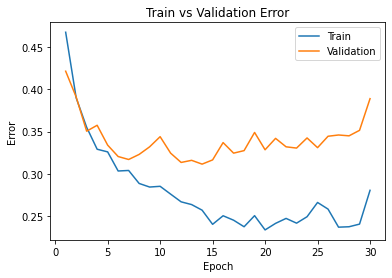

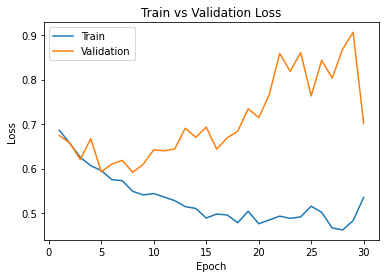

In [24]:
large_net = LargeNet()
large_net_large_lr = train_net(large_net, learning_rate=0.1)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

Training took roughly the same amount of time, i.e., 130 seconds vs 128 seconds.This makes sense as we are just multiplying the gradient computation by a smaller amount, so the operations are the same. However, we do see that the loss curves are poorly behaved in that the validation loss is going up quite a bit, and even the training loss is too. This is also a very unstable curve since the loss curves are not smoother, which is due to the optimizer "bouncing" around the loss landscape when the learning rate is too high (steps towards the global minima are too large). Also the model is overfit as training error is much lower than the validation error and both are going up. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

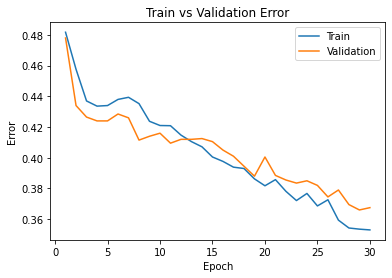

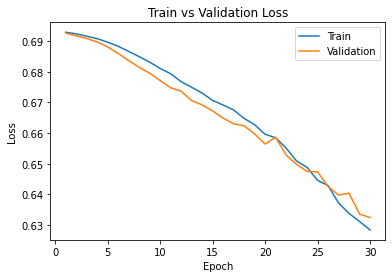

In [25]:
large_net = LargeNet()
large_net_large_batch = train_net(large_net, batch_size=512)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Training with a larger batch led to shorter training times, i.e., 118 seconds vs 130 seconds. Additionally, the loss curves are better behaved, i.e., they are not overfit and the validation curves closely follows that of the training curve. Also, the model doesn't overfit as fast and has more stable curves, i.e., they are smoother. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

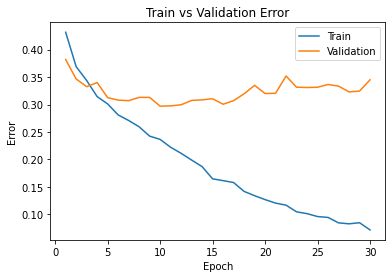

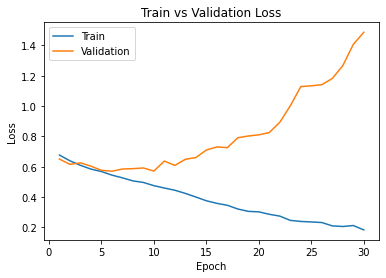

In [26]:
large_net = LargeNet()
large_net_small_batch = train_net(large_net, batch_size=16)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Training with a smaller batch led to longer training times, i.e., 188 seconds vs 130 seconds. Additionally, the loss curves are poorly behaved, i.e., they are clearly overfit (validation loss/error much higher than training loss/error and increasing while training loss/error is still decreasing). Also, while the curves are fairly smooth, the model seems to immedately overfit, meaning the optimizer is going into rather poor regions of the loss landscape that have bad local optima, where associated parameters correlate to fitting data noise. 

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

If we are comfortable with a longer training period, we can choose a smaller learning_rate, especially with a larger network. This helps smooth out the loss curves as we take smaller steps towards the global minima. Further, we can take a larger (but not too large) `batch_size` in order to help improve genearlization on this dataset. We should also use the large network as it has more capacity (more parameters/layers) that would help model genearlization. 

So I propose: 

*   `learning_rate` = 0.006
*   `batch_size` = 256
*   `num_epochs` = 150



### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47525, Train loss: 0.6928301826119423 |Validation err: 0.4635, Validation loss: 0.6923908442258835
Epoch 2: Train err: 0.448625, Train loss: 0.6920892838388681 |Validation err: 0.4395, Validation loss: 0.6911498829722404
Epoch 3: Train err: 0.431125, Train loss: 0.6911100950092077 |Validation err: 0.416, Validation loss: 0.6899418979883194
Epoch 4: Train err: 0.430625, Train loss: 0.6896353028714657 |Validation err: 0.421, Validation loss: 0.6877869814634323
Epoch 5: Train err: 0.437625, Train loss: 0.6878515146672726 |Validation err: 0.424, Validation loss: 0.6849464699625969
Epoch 6: Train err: 0.43275, Train loss: 0.6858931612223387 |Validation err: 0.4165, Validation loss: 0.6822742894291878
Epoch 7: Train err: 0.43025, Train loss: 0.6835607439279556 |Validation err: 0.4115, Validation loss: 0.6794741526246071
Epoch 8: Train err: 0.42375, Train loss: 0.6814770270138979 |Validation err:

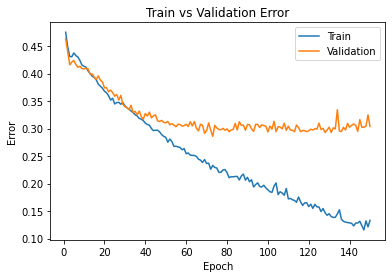

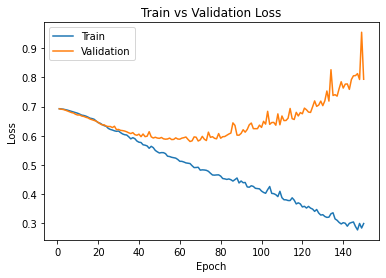

In [27]:
large_net = LargeNet()
large_net_custom_1 = train_net(large_net, batch_size=256, learning_rate=0.006, num_epochs=150)
model_path = get_model_name("large", batch_size=256, learning_rate=0.006, epoch=149)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

The choice of hyperparameters from part a suggest that I have a seriously overfit model, especially looking at the validation loss curve. For the next set of hyperparameters, I will choose a much smaller learning rate. Specifically, I'll choose 0.002, and I'll up the batch size to 384 for faster training. Also I'll up the `num_epochs` to 300 to account for the lower learning rate. 

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.501875, Train loss: 0.6935614432607379 |Validation err: 0.4915, Validation loss: 0.6920569837093353
Epoch 2: Train err: 0.50075, Train loss: 0.6931842735835484 |Validation err: 0.486, Validation loss: 0.6917946537335714
Epoch 3: Train err: 0.4995, Train loss: 0.6927901648339772 |Validation err: 0.466, Validation loss: 0.6917387545108795
Epoch 4: Train err: 0.491625, Train loss: 0.6924529529753185 |Validation err: 0.4435, Validation loss: 0.6912098924318949
Epoch 5: Train err: 0.47975, Train loss: 0.6920922824314663 |Validation err: 0.44, Validation loss: 0.6913504600524902
Epoch 6: Train err: 0.47275, Train loss: 0.6917929507437206 |Validation err: 0.438, Validation loss: 0.6911609967549642
Epoch 7: Train err: 0.4645, Train loss: 0.6914707337106977 |Validation err: 0.4305, Validation loss: 0.6903672814369202
Epoch 8: Train err: 0.46475, Train loss: 0.6911416791734242 |Validation err: 0.429

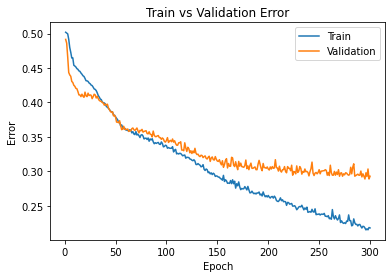

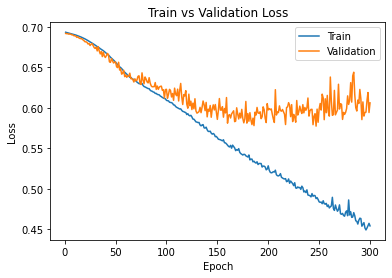

In [32]:
large_net = LargeNet()
large_net_custom_1 = train_net(large_net, batch_size=384, learning_rate=0.002, num_epochs=300)
model_path = get_model_name("large", batch_size=384, learning_rate=0.002, epoch=299)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [33]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=384, learning_rate=0.002, epoch=299)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I chose this specific model because it has the most consistently lowest validation loss, meaning that the optima that the optimizer reached is likely to be actually good for genearlization performance. Specifically, this model scored around 0.29 for the validation loss consistently over nearly 100 (1/3 of total) epochs, which is something the other models were unable to achieve. I chose the final epoch since it had the loweset validation error that I saw training this model, and in the ~50 epochs before it, the model also achieved roughly the same validaiton loss, so at epoch 300, the optimizer reached a satisfactory region of the loss landscape. 

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [35]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=384)

evaluate(net, test_loader, nn.BCEWithLogitsLoss())

Files already downloaded and verified
Files already downloaded and verified


(0.2945, 0.5806906521320343)

The test classification error is only 0.2945 using the model from part a. 

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error is slightly higher than that of the validation error (0.2945 vs 0.293 respectively), which is expected since we biased our model to perform well on the validation set. This means we likely biased the hyperparameters to optimize over the data noise of the validation set, which is probably not present in the test set. 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

Because it is our "hold out" set, meaning that it should simulate us testing the model on different data in the real world, e.g., if we encounter some picture of a cat or dog on the internet and wanted to classify it. In the same way a student may save practice exams for a simulated testing environment, we should only use the test set as little as possible so that we can learn the over all data (or class material) rather than the test set specific features (or practice exam specific questions). 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [43]:
class SmallestNet(nn.Module):
    def __init__(self, hid_dim = 16, activation=nn.Mish()):
        super(SmallestNet, self).__init__()
        self.name = "smallest"
        self.hidden_1 = nn.Linear(3*32*32, hid_dim*hid_dim)
        self.activation_1 = activation
        self.hidden_2 = nn.Linear(hid_dim*hid_dim, 1)

    def forward(self, x):
        x = x.reshape(-1, 3*32*32)
        h = self.hidden_1(x)
        h = self.activation_1(h)
        out = self.hidden_2(h)
        return out.squeeze(1)

In [33]:
train_loader.dataset[0][0].shape

torch.Size([1, 3, 32, 32])


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43975, Train loss: 0.6790264807641506 |Validation err: 0.397, Validation loss: 0.6673664301633835
Epoch 2: Train err: 0.3955, Train loss: 0.6588614992797375 |Validation err: 0.3905, Validation loss: 0.6591461896896362
Epoch 3: Train err: 0.380625, Train loss: 0.6512074321508408 |Validation err: 0.3955, Validation loss: 0.6565362364053726
Epoch 4: Train err: 0.371625, Train loss: 0.6434310004115105 |Validation err: 0.395, Validation loss: 0.6549622416496277
Epoch 5: Train err: 0.36625, Train loss: 0.6371243260800838 |Validation err: 0.39, Validation loss: 0.6516404896974564
Epoch 6: Train err: 0.359375, Train loss: 0.6314536742866039 |Validation err: 0.3805, Validation loss: 0.6502120941877365
Epoch 7: Train err: 0.3515, Train loss: 0.6276301816105843 |Validation err: 0.3835, Validation loss: 0.655967190861702
Epoch 8: Train err: 0.354125, Train loss: 0.6252319328486919 |Validation err: 0.3

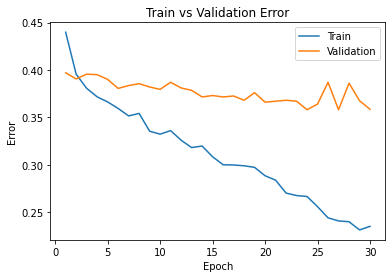

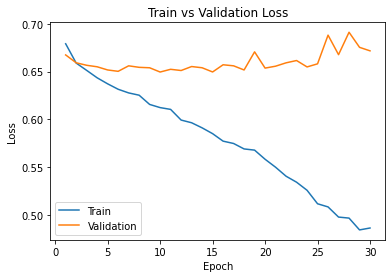

In [40]:
smallest_net = SmallestNet()
smallest_net_1 = train_net(smallest_net, batch_size=512, learning_rate=0.02, num_epochs=30)
model_path = get_model_name("smallest", batch_size=512, learning_rate=0.02, epoch=29)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44925, Train loss: 0.6830242313444614 |Validation err: 0.406, Validation loss: 0.6708525121212006
Epoch 2: Train err: 0.4035, Train loss: 0.666317768394947 |Validation err: 0.392, Validation loss: 0.6625947654247284
Epoch 3: Train err: 0.3875, Train loss: 0.6572890840470791 |Validation err: 0.3945, Validation loss: 0.6603899747133255
Epoch 4: Train err: 0.38375, Train loss: 0.6523421891033649 |Validation err: 0.399, Validation loss: 0.6578977108001709
Epoch 5: Train err: 0.3805, Train loss: 0.6475777365267277 |Validation err: 0.3915, Validation loss: 0.6559290736913681
Epoch 6: Train err: 0.374125, Train loss: 0.6449547596275806 |Validation err: 0.396, Validation loss: 0.6560088843107224
Epoch 7: Train err: 0.369875, Train loss: 0.6414322219789028 |Validation err: 0.39, Validation loss: 0.6536260694265366
Epoch 8: Train err: 0.364375, Train loss: 0.6360941492021084 |Validation err: 0.378, 

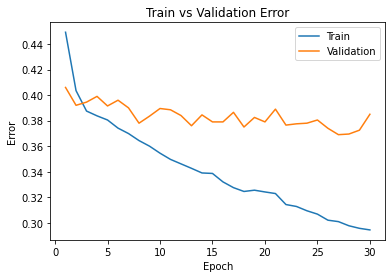

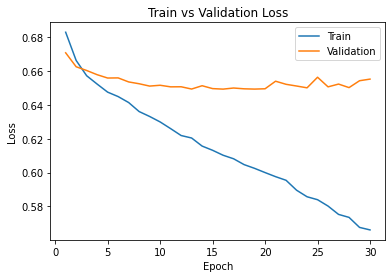

In [41]:
smallest_net = SmallestNet()
smallest_net_1 = train_net(smallest_net, batch_size=512, learning_rate=0.01, num_epochs=30)
model_path = get_model_name("smallest", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4215, Train loss: 0.675833947956562 |Validation err: 0.396, Validation loss: 0.6674904227256775
Epoch 2: Train err: 0.395375, Train loss: 0.6590367667376995 |Validation err: 0.3925, Validation loss: 0.6609920561313629
Epoch 3: Train err: 0.383125, Train loss: 0.6531109102070332 |Validation err: 0.3905, Validation loss: 0.6596569418907166
Epoch 4: Train err: 0.375625, Train loss: 0.6467069685459137 |Validation err: 0.3915, Validation loss: 0.6578879207372665
Epoch 5: Train err: 0.37175, Train loss: 0.6420910581946373 |Validation err: 0.388, Validation loss: 0.6557555645704269
Epoch 6: Train err: 0.36925, Train loss: 0.6386721320450306 |Validation err: 0.384, Validation loss: 0.6538977771997452
Epoch 7: Train err: 0.3675, Train loss: 0.6363576911389828 |Validation err: 0.3835, Validation loss: 0.6574136763811111
Epoch 8: Train err: 0.36175, Train loss: 0.6331921070814133 |Validation err: 0.3

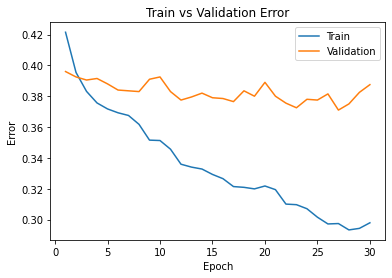

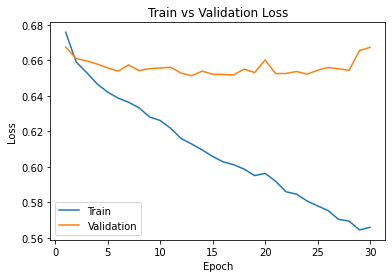

In [44]:
smallest_net = SmallestNet(hid_dim=64)
smallest_net_1 = train_net(smallest_net, batch_size=512, learning_rate=0.01, num_epochs=30)
model_path = get_model_name("smallest", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
smallest_net = SmallestNet(hid_dim=64)
smallest_net_1 = train_net(smallest_net, batch_size=32, learning_rate=0.01, num_epochs=30)
model_path = get_model_name("smallest", batch_size=32, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
smallest_net = SmallestNet(hid_dim=8)
smallest_net_1 = train_net(smallest_net, batch_size=32, learning_rate=0.01, num_epochs=30)

In [48]:
model_path = get_model_name("smallest", batch_size=32, learning_rate=0.01, epoch=9)
plot_training_curve(model_path)

OSError: ignored